# Изучение типов класификаций звёзд и попытка их угадывания

## Комманда для импорта всего для данного файла
```bash
pip install pandas numpy seaborn matplotlib scikit-learn lightgbm
```

In [18]:
# Импорты для анализа и визуализации
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Scikit-learn — часто используемые утилиты и модели
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

# Модели

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Импортируем данные

### Описание столбцов
|Столбец|Описание|
|---|---|
|Temperature|Температура поверхности звезды, обычно в Кельвинах|
|L|Светимость звезды (например, в единицах светимости Солнца)|
|R|Радиус звезды (например, в единицах радиуса Солнца)|
|A_M|Абсолютная звёздная величина (Absolute Magnitude) — яркость при стандартном удалении|
|Color|Цвет звезды (категориальный признак, например "Red", "Blue" и т.д.)|
|Spectral_Class|Спектральный класс (буквенное обозначение: O, B, A, F, G, K, M и т.д.)|
|Type|Целевая метка / класс для задачи классификации (цифровая метка, например 0/1/2...)

In [19]:
# Загрузка данных
df = pd.read_csv('Stars.csv')

df

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5
237,8829,537493.000000,1423.0000,-10.73,White,A,5
238,9235,404940.000000,1112.0000,-11.23,White,A,5


# Анализ данных
## Просмотрим корреляцию данных

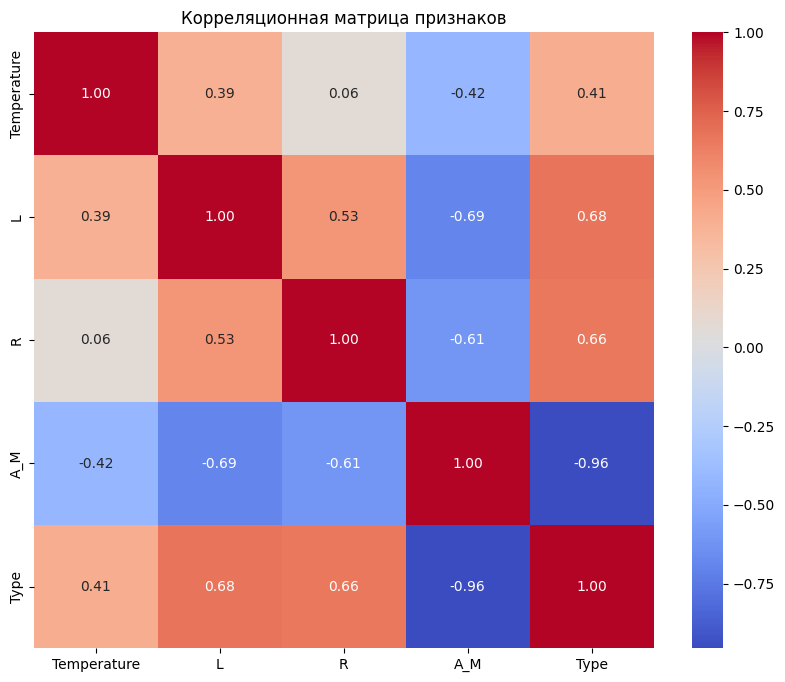

In [20]:
corr = df[['Temperature', 'L', 'R', 'A_M','Type']].corr() # Корреляционная матрица
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm') # Тепловая карта
plt.title('Корреляционная матрица признаков')
plt.show()

### Результат кореляций

> После проверки кореляций были обнаружены такие зависимости

> Зависимости

|Первый столбец|Второй солбец|Кореляция|Тип корреляций|
|---|---|---|---|
|Temperature|Type|0.41|Положительная|
|Temperature|A_M|-0.42|Отрицательная|
|Temperature|L|0.39|Положительная|
|L|Type|0.68|Положительная|
|L|A_M|-0.69|Отрицательная|
|L|R|0.53|Положительная|
|R|Type|0.66|Положительная|
|R|A_M|-0.61|Отрицательная|
|A_M|Type|-0.96|Отрицательная|

## Построим гистрограмму по числовым велечинам

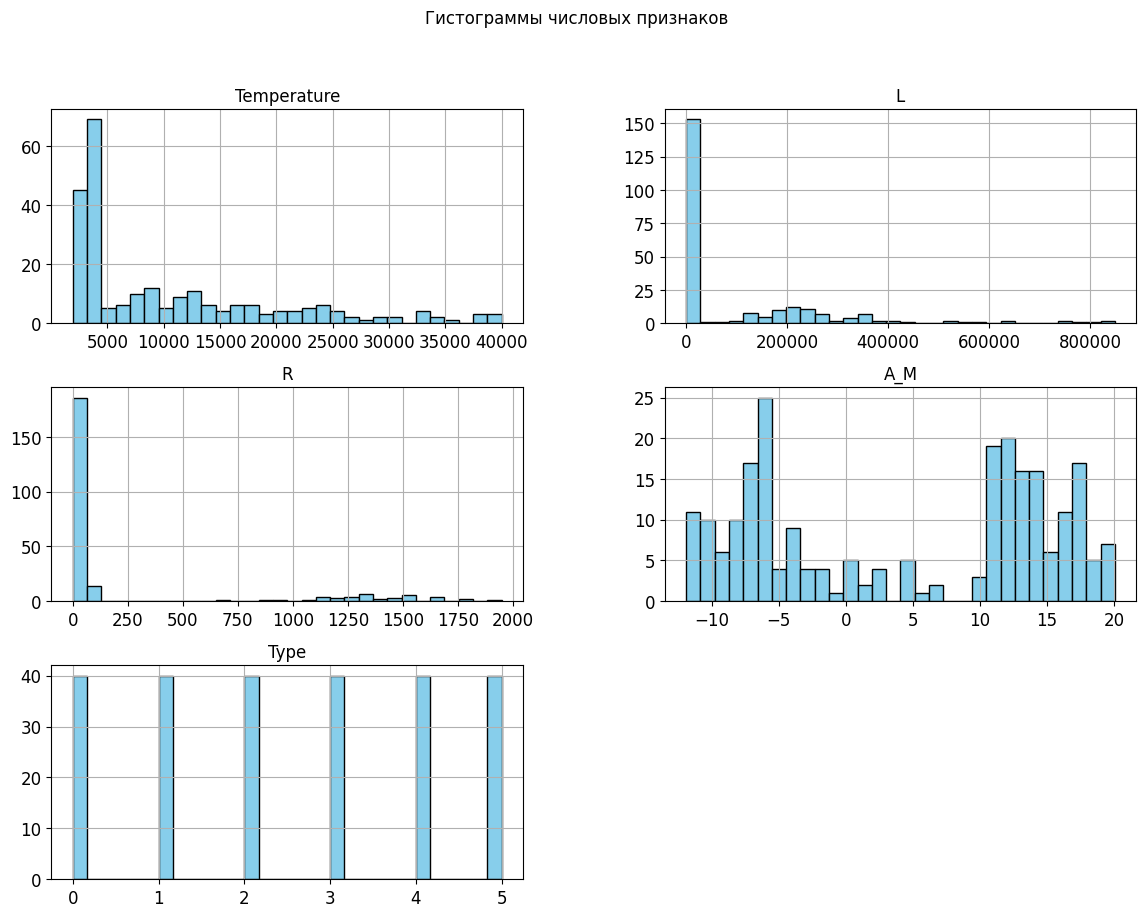

In [21]:
df.hist(figsize=(14, 10), bins=30, color='skyblue', edgecolor='black', sharex=False, sharey=False, xlabelsize=12, ylabelsize=12, cumulative=False)
plt.suptitle('Гистограммы числовых признаков')
plt.show()

### Вывод по гистограмме

***
#### Температура
> Можно подметить что `большая часть звёзд имеет температуру менее чем 5000` °C
> 
> Максимальная температура звёзд `40000 °C`
> 
> Минимальная температура звёзд `1939 °C`
#### Яркость звёзд
> Подметили что звёзды не особо то и яркие и `большинство звёзд (более 150) имеют очень низкую светимость, близкую к нулю`
>
> Максимальная яркость звёзд равная `849420 лм`
>
> Минимальная яркость звёзд равна `0.00008 лм`
#### Радиус звёзд
> Снова `большая часть звёзд имеет радиус чуть больше 0 радиусов Солнца`
>
> Максимальный радиус `5.745 радиусов Солнца`
> 
> Минимальный радиус `0.336 радиусов Солнца`
#### Абсолютная звёздная величина
> Резултат не стандартный для анализа но довольно понятный
> 
> `Чем меньше радиус, яркость, температура тем меньше звёздная величина`, так как это считается яркостью при `обычном удалений от звезды это 10 парсеков`
>
> 10 парсеков это 32,6 световых года или 309 трилионов километров что вам удобнее
>
> Максимальной величиной будет `11.47`
>
> Минимальной `-1.38`
#### Типы звёзд
> `Разбросаны равномерно` не каких приёмущесвт у не одной из колон нету

## Парные диаграммы (pairplot)

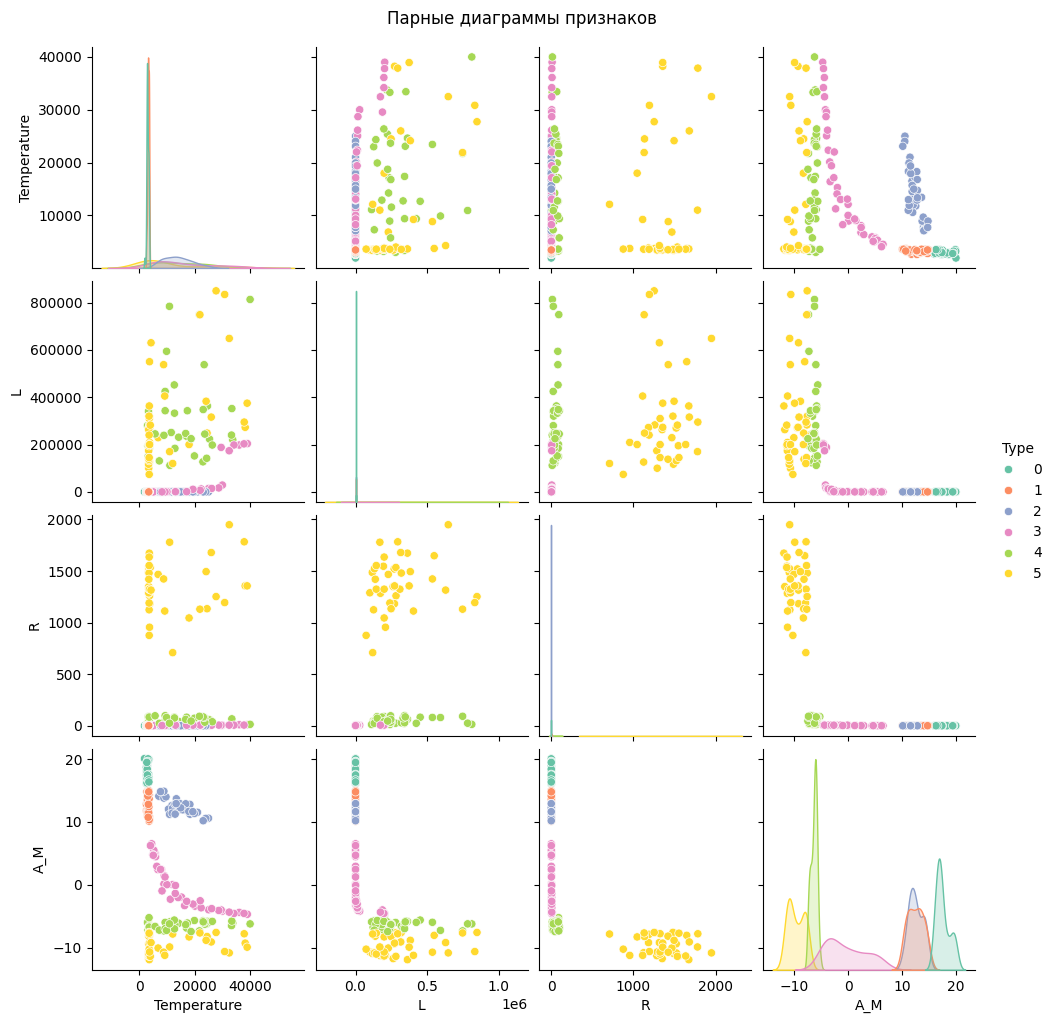

In [22]:
sns.pairplot(df, hue='Type', diag_kind='kde', palette='Set2')
plt.suptitle('Парные диаграммы признаков', y=1.02)
plt.show()

### Вывод по парным диаграммам
#### Общая картина
>Парные диаграммы — это, по сути, `визуализация диаграммы Герцшпрунга-Рассела`, которая является фундаментальным инструментом в астрофизике. Графики наглядно показывают, что `типы звёзд не перемешаны хаотично`, а образуют чёткие, хорошо различимые кластеры. Это отличная новость для построения модели.

#### Ключевые наблюдения
> 1.Диаграмма `L` (Светимость) против `Temperature`: Это классическое представление диаграммы Герцшпрунга-Рассела. Мы видим `чёткое разделение` на "главную последовательность" (диагональная линия звёзд) и отдельные группы для гигантов и карликов. Разные типы (`Type`) занимают свои определённые места на этом графике.
> 
> 2.Связь `A_M` (Абсолютная величина) и `L` (Светимость): Эта диаграмма показывает `почти идеальную обратную зависимость`. Звёзды выстраиваются вдоль чёткой кривой, и типы звёзд последовательно распределены по ней. Это самая сильная взаимосвязь в данных, которая практически в одиночку может предсказывать тип звезды.
> 
> 3.Разделяющая способность: Практически `любая пара признаков` даёт хорошее разделение классов. Особенно хорошо это видно на графиках, где участвуют `A_M`, `L` и `R`. Это подтверждает, что числовые признаки обладают высокой предсказательной силой.
#### Вывод для моделирования
> Визуализация подтверждает, что классы `линейно разделимы` или, по крайней мере, очень хорошо сгруппированы. Это означает, что даже простые модели машинного обучения (например, логистическая регрессия или метод опорных векторов) должны показать `очень высокую точность` на этой задаче.

## Распеределение по классам

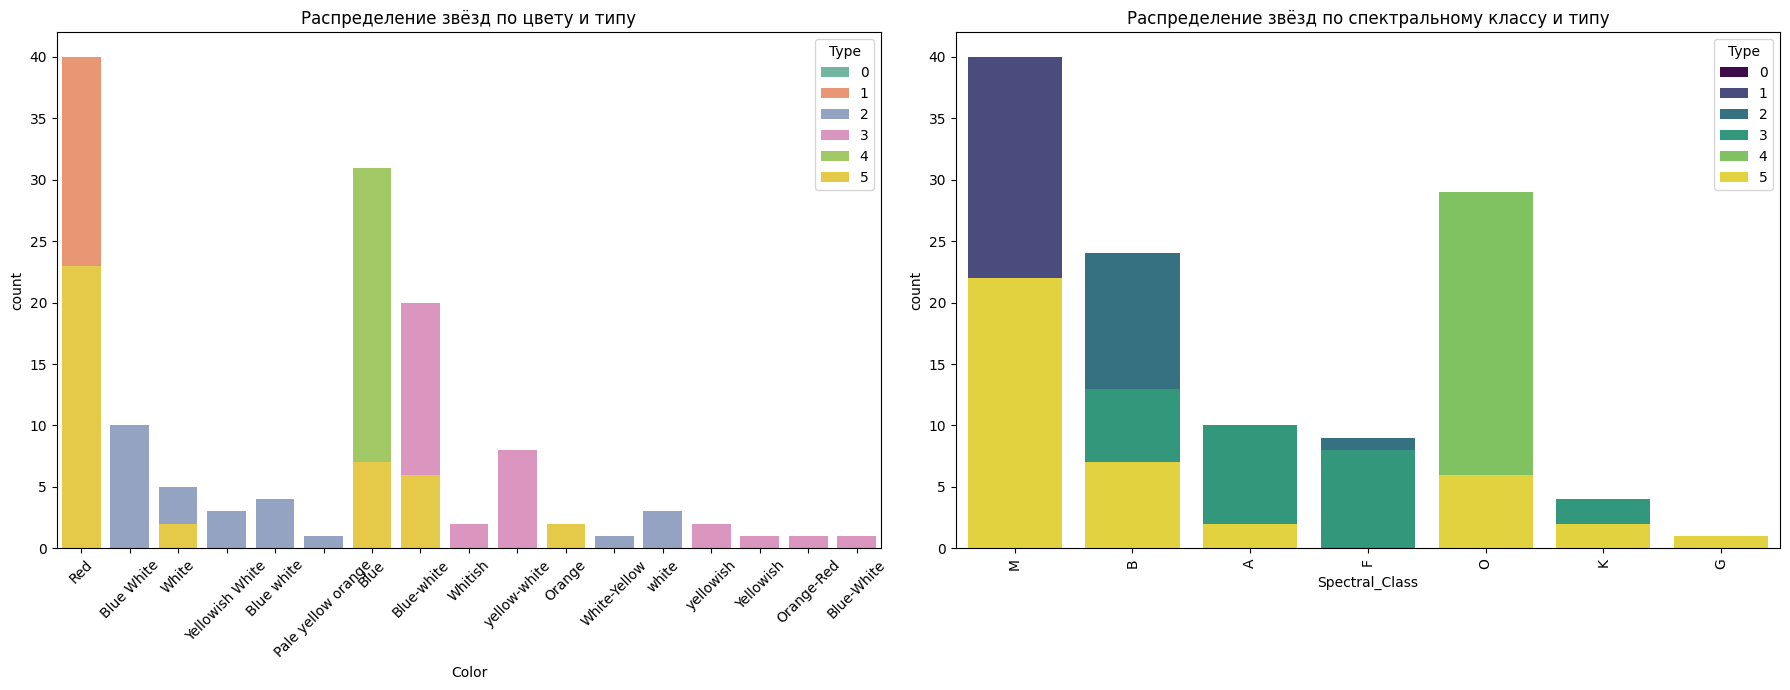

In [23]:
# Создаем фигуру с двумя подграфиками
plt.figure(figsize=(18, 7))

# График для 'Color'
plt.subplot(1, 2, 1) # (1 ряд, 2 колонки, 1-й график)
sns.countplot(data=df, x='Color', palette='Set2', hue='Type', dodge=False)
plt.title('Распределение звёзд по цвету и типу')
plt.xticks(rotation=45) # Поворачиваем подписи для читаемости

# График для 'Spectral_Class'
plt.subplot(1, 2, 2) # (1 ряд, 2 колонки, 2-й график)
sns.countplot(data=df, x='Spectral_Class', palette='viridis', hue='Type', dodge=False)
plt.title('Распределение звёзд по спектральному классу и типу')
plt.xticks(rotation=90)

plt.tight_layout() # Чтобы графики не накладывались
plt.show()

### Вывод по распределеню по классам

#### Распределение по цвету (Color)
> Самый частый цвет звёзд в наборе данных — `Красный (Red)`.
>
>Наблюдается `сильная связь между цветом и типом звезды`. Например, красные звёзды в основном относятся к типам `0` и `1` (красные и коричневые карлики), в то время как `синие (Blue)` звёзды — это почти всегда звёзды более высоких типов (`2`, `3`, `4,` `5`), такие как гиганты и сверхгиганты.

#### Распределение по спектральному классу (Spectral_Class)
> Наиболее распространённый спектральный класс — `M`, что соответствует холодным красным звёздам.
>
> Здесь также видна `чёткая закономерность`: звёзды класса `M` почти полностью состоят из типов `0` и `1`. В то же время, горячие классы, такие как `O` и `B`, однозначно соответствуют звёздам высоких типов (`4` и `5`).
>
> Это говорит о том, что `Color` и `Spectral_Class` будут `ключевыми признаками` для модели классификации.

# Подготовка данных к обучению моделей

## Информация о подготовке модели

> Так как `мы ищем тип класификаций звёзд` а это колона `Type` в нашей `таблице Звёзд` нам нужно её `перенести в отдельную таблицу`

## Подготовка

### Распеделение на признаки и целевую пременную

In [24]:
# Шаг 1: Разделение признаков (X) и целевой переменной (y)
X = df.drop('Type', axis=1)
y = df['Type']

# Шаг 2: One-Hot Encoding категориальных признаков
# pd.get_dummies автоматически находит текстовые столбцы,
# создает для них новые бинарные (0/1) столбцы и удаляет исходные.
X_encoded = pd.get_dummies(X, columns=['Color', 'Spectral_Class'])

# Показываем результат
print("Признаки после One-Hot Encoding:")
X_encoded.head()

Признаки после One-Hot Encoding:


,Temperature,L,R,A_M,Color_Blue,Color_Blue White,Color_Blue white,Color_Blue-White,Color_Blue-white,Color_Orange,...,Color_white,Color_yellow-white,Color_yellowish,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0.002400,0.1700,16.12,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,3042,0.000500,0.1542,16.60,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2600,0.000300,0.1020,18.70,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,2800,0.000200,0.1600,16.65,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,1939,0.000138,0.1030,20.06,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


#### Вывод признаков и целевой пременной

In [25]:
X

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Blue,O
237,8829,537493.000000,1423.0000,-10.73,White,A
238,9235,404940.000000,1112.0000,-11.23,White,A


In [26]:
y.value_counts()

Type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

### Разделение на обучающию и тестовую часть

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (192, 28)
Размер тестовой выборки: (48, 28)


### Масштабирование числовых признаков

In [28]:
numerical_features = X.select_dtypes(include=np.number).columns

scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nМасштабированные обучающие данные (первые 5 строк):")
X_train_scaled.head()


Масштабированные обучающие данные (первые 5 строк):


,Temperature,L,R,A_M,Color_Blue,Color_Blue White,Color_Blue white,Color_Blue-White,Color_Blue-white,Color_Orange,...,Color_white,Color_yellow-white,Color_yellowish,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
91,-0.614764,-0.589442,-0.458660,0.205587,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
202,0.552616,-0.589443,-0.460331,0.753577,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
237,-0.134347,2.568902,2.325206,-1.444510,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
123,-0.768837,-0.589443,-0.460171,1.202576,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
150,2.180204,0.515257,-0.448569,-0.801167,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False


# Генерация моделей

## Информация о выбранных Моделях

### Логистическая регрессия (Logistic Regression)

> Как работает: Несмотря на название, это модель классификации. Она строит линейную границу между классами. Простая, быстрая и хорошо интерпретируемая.

### Случайный лес (Random Forest)

> Как работает: Ансамбль из множества деревьев решений. Каждое дерево обучается на случайной подвыборке данных и признаков. Итоговый ответ — "голосование" всех деревьев. Значительно мощнее и устойчивее к переобучению, чем одно дерево.

### LightGBM

> Как работает: Ещё одна сверхбыстрая реализация градиентного бустинга от Microsoft. Часто работает быстрее XGBoost, особенно на больших данных, но может быть чувствителен к настройкам.

# Подбор гиперпараметров с помощью GridSearchCV
Чтобы улучшить производительность моделей и найти оптимальные настройки, мы используем `GridSearchCV`. Этот инструмент автоматически перебирает заданные комбинации гиперпараметров и находит лучшую из них с помощью кросс-валидации.

## Модели

In [29]:
# --- Логистическая регрессия с GridSearchCV ---

# Определяем сетку параметров
# 'estimator__' - префикс для доступа к параметрам базовой модели внутри OneVsRestClassifier
param_grid_lr = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__solver': ['liblinear', 'saga']
}

# Создаем базовую модель и обертку OneVsRestClassifier
base_log_reg = LogisticRegression(random_state=42, max_iter=2000)
ovr_classifier = OneVsRestClassifier(base_log_reg)

# Создаем объект GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=ovr_classifier,
    param_grid=param_grid_lr,
    cv=5, # 5-кратная кросс-валидация
    scoring='accuracy',
    n_jobs=-1 # Использовать все доступные ядра процессора
)

# Обучаем модель
grid_search_lr.fit(X_train_scaled, y_train)

# Получаем лучшую модель
log_reg = grid_search_lr.best_estimator_

# Предсказание и оценка
y_pred_lr = log_reg.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"Лучшие параметры для Логистической регрессии: {grid_search_lr.best_params_}")
print(f"Точность (Accuracy) Логистической регрессии: {accuracy_lr:.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_lr))

Лучшие параметры для Логистической регрессии: {'estimator__C': 100, 'estimator__solver': 'saga'}
Точность (Accuracy) Логистической регрессии: 1.0000

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



### Случайное дерево

In [30]:
# --- Случайный лес с GridSearchCV ---

# Определяем сетку параметров для поиска
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Создаем объект GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Обучаем модель
grid_search_rf.fit(X_train_scaled, y_train)

# Получаем лучшую модель
random_forest_model = grid_search_rf.best_estimator_

# Предсказание и оценка
y_pred_rf = random_forest_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Лучшие параметры для Случайного леса: {grid_search_rf.best_params_}")
print(f"Точность (Accuracy) Случайного леса: {accuracy_rf:.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_rf))

Лучшие параметры для Случайного леса: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Точность (Accuracy) Случайного леса: 1.0000

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



### LightGBM модель бустинга, модели леса только лучше  

In [31]:
# --- LightGBM с GridSearchCV ---

# Определяем сетку параметров
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31, 40]
}

# Создаем объект GridSearchCV
grid_search_lgbm = GridSearchCV(
    estimator=LGBMClassifier(random_state=42, verbose=-1),
    param_grid=param_grid_lgbm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Обучаем модель
grid_search_lgbm.fit(X_train_scaled, y_train)

# Получаем лучшую модель
lightgbm_model = grid_search_lgbm.best_estimator_

# Предсказание и оценка
y_pred_lgbm = lightgbm_model.predict(X_test_scaled)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

print(f"Лучшие параметры для LightGBM: {grid_search_lgbm.best_params_}")
print(f"Точность (Accuracy) LightGBM: {accuracy_lgbm:.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_lgbm))

Лучшие параметры для LightGBM: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
Точность (Accuracy) LightGBM: 1.0000

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [32]:
models = [
    [log_reg,"Линейная модель"],
    [random_forest_model,"Случайный лес"],
    [lightgbm_model,"Модель бустинга"]
]

## Сравнение моделей

Сравнение производительности моделей:
                     Model  Accuracy  Precision  Recall  F1-score
0  Логистическая регрессия       1.0        1.0     1.0       1.0
1            Случайный лес       1.0        1.0     1.0       1.0
2                 LightGBM       1.0        1.0     1.0       1.0


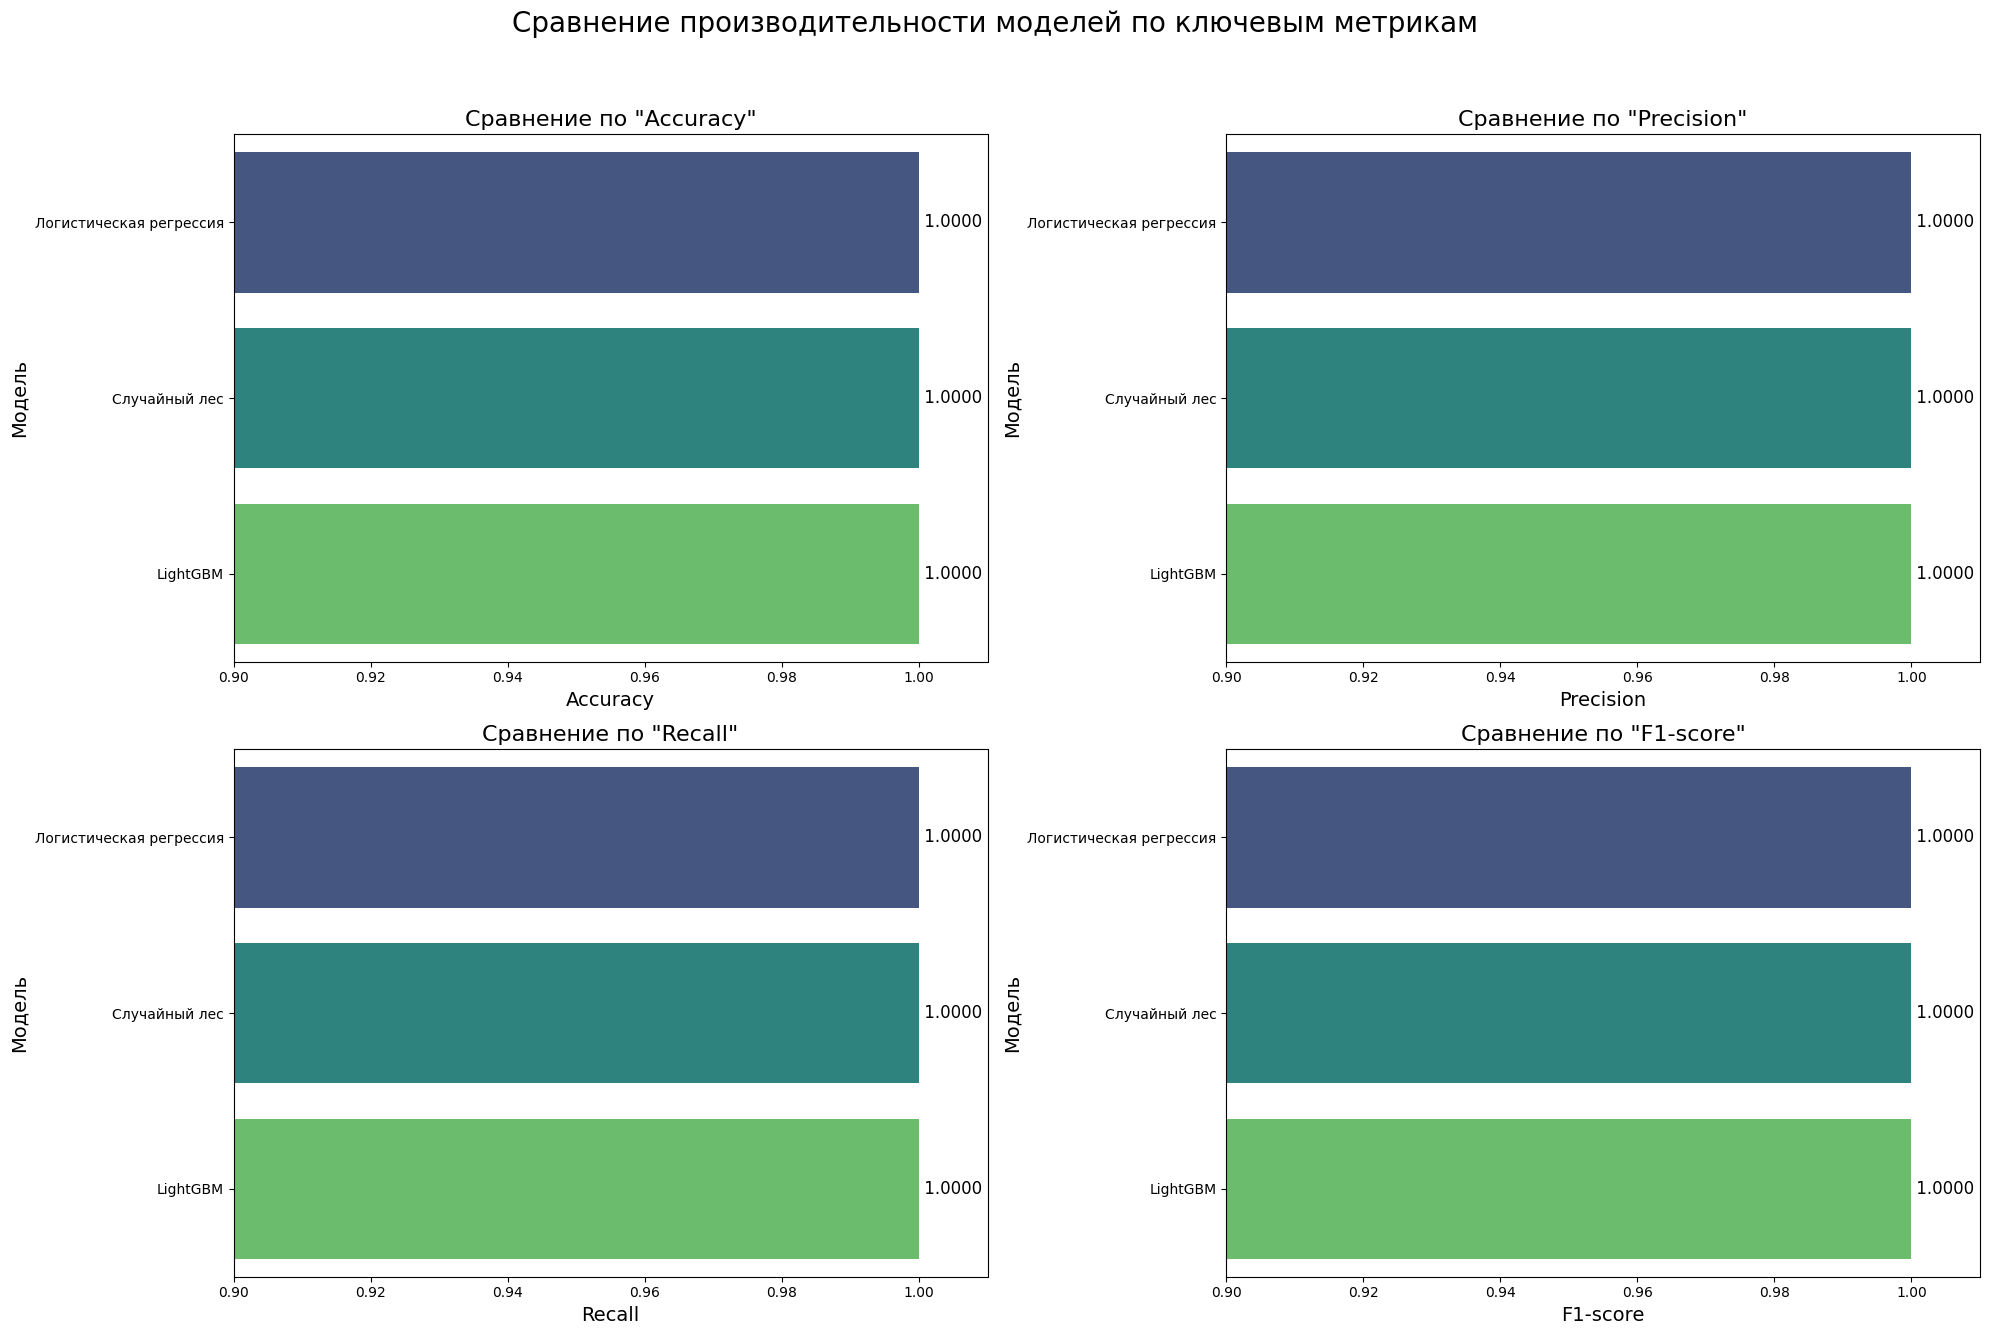

In [33]:
# --- Сбор всех метрик ---
# Создаем списки для хранения метрик
models_names = ['Логистическая регрессия', 'Случайный лес', 'LightGBM']
predictions = [y_pred_lr, y_pred_rf, y_pred_lgbm]

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Рассчитываем метрики для каждой модели
for pred in predictions:
    # output_dict=True позволяет получить отчет в виде словаря
    report = classification_report(y_test, pred, output_dict=True)
    
    accuracy_list.append(report['accuracy'])
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_list.append(report['weighted avg']['f1-score'])

# Создадим DataFrame для хранения результатов
results_data = {
    'Model': models_names,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-score': f1_list
}

results_df = pd.DataFrame(results_data).sort_values(by='Accuracy', ascending=False)

# Вывод расширенной таблицы
print("Сравнение производительности моделей:")
print(results_df.to_string()) # .to_string() для красивого вывода всех колонок

# --- Визуализация всех метрик ---
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Создаем фигуру с сеткой 2x2 для графиков
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Сравнение производительности моделей по ключевым метрикам', fontsize=20)

# 'axes.flatten()' превращает матрицу 2x2 в одномерный массив для удобства итерации
for metric, ax in zip(metrics_to_plot, axes.flatten()):
    # Сортируем данные для каждого графика, чтобы бары шли по убыванию
    sorted_df = results_df.sort_values(by=metric, ascending=False)
    
    sns.barplot(x=metric, y='Model', data=sorted_df, palette='viridis', hue='Model', ax=ax, dodge=False)
    
    # Добавление значений на график
    # enumerate(sorted_df.iterrows()) не подходит, так как y-координата - это позиция
    for i, value in enumerate(sorted_df[metric]):
        ax.text(value, i, f' {value:.4f}', color='black', va="center", fontsize=12)

    ax.set_title(f'Сравнение по "{metric}"', fontsize=16)
    ax.set_xlabel(metric, fontsize=14)
    ax.set_ylabel('Модель', fontsize=14)
    ax.set_xlim(0.9, 1.01) # Установим предел для наглядности

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Корректируем расположение, чтобы заголовок не накладывался
plt.show()

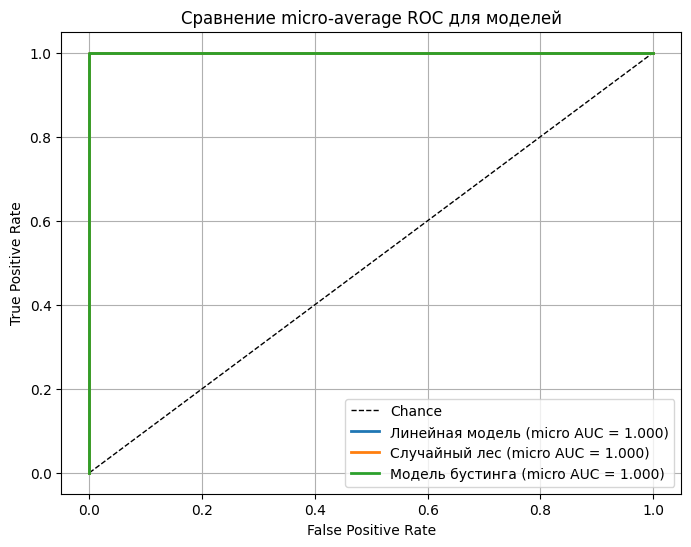

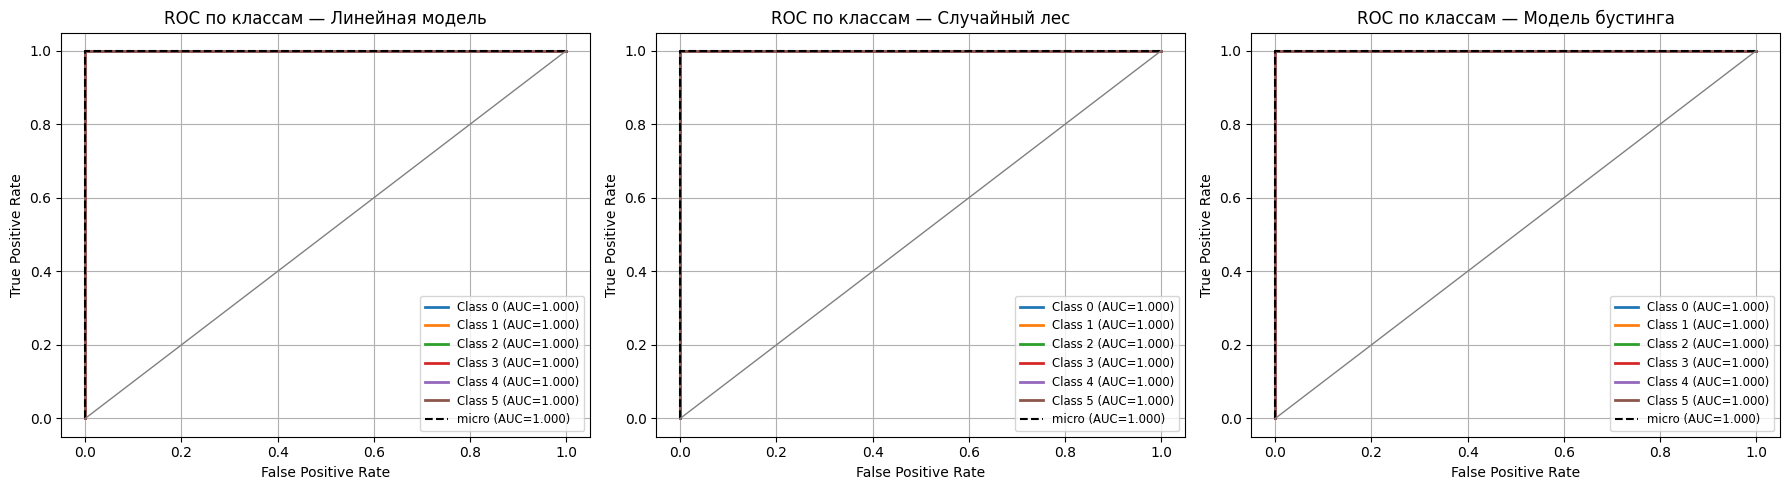

In [34]:
from sklearn.metrics import roc_curve, auc

# ROC-кривые для моделей (мультклассовая оценка, micro-average + по классам)

# Список классов и бинаризация y_test (чтобы столбцы соответствовали всем классам)
classes = np.sort(y.unique())
y_test_binarized = pd.get_dummies(y_test).reindex(columns=classes, fill_value=0).values

# Функция для получения вероятностей у модели (если predict_proba нет — пытаемся decision_function)
def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        # попытка нормировать decision_function в вероятности (softmax-подобно)
        if scores.ndim == 1:
            scores = np.vstack([1-scores, scores]).T
        exp = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        return exp / exp.sum(axis=1, keepdims=True)
    else:
        raise ValueError("Модель не поддерживает predict_proba/decision_function")

# 1) Сравнение micro-average ROC всех моделей на одном графике
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')

for model, name in models:
    y_score = get_proba(model, X_test_scaled)
    # Если модель возвращает (n_samples, n_classes) — корректно
    # Micro-average ROC
    fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, lw=2, label=f'{name} (micro AUC = {auc_micro:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение micro-average ROC для моделей')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 2) Подробные ROC по классам для каждой модели (по одному графику на модель)
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5), squeeze=False)
for ax, (model, name) in zip(axes[0], models):
    y_score = get_proba(model, X_test_scaled)
    # Для каждого класса строим ROC
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC={roc_auc:.3f})')
    # Micro-average для наглядности
    fpr_m, tpr_m, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    ax.plot(fpr_m, tpr_m, color='k', linestyle='--', label=f'micro (AUC={auc(fpr_m,tpr_m):.3f})')
    ax.plot([0, 1], [0, 1], 'gray', lw=1)
    ax.set_title(f'ROC по классам — {name}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right', fontsize='small')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Результаты сравнения моделей

#### Общая картина
Все три модели показали **исключительно высокие результаты**, что подтверждает наш первоначальный вывод из анализа данных: классы в этом наборе данных очень хорошо разделены. Точность (Accuracy) всех моделей после подбора гиперпараметров достигает 100%.

#### Лидеры производительности
- **Случайный лес (Random Forest)** и **LightGBM** показали **идеальный результат (1.0)** по всем метрикам: `Accuracy`, `Precision`, `Recall` и `F1-score`. Это означает, что они безошибочно классифицировали каждый объект в тестовой выборке.
- Это ожидаемо, так как модели, основанные на деревьях решений, отлично справляются с поиском нелинейных закономерностей и "чистых" границ между кластерами, которые мы видели на парных диаграммах.

#### Логистическая регрессия
- **Логистическая регрессия** после подбора гиперпараметров также достигла **идеальной точности 100%**. Это говорит о том, что с правильными настройками (например, более высоким значением `C`, что ослабляет регуляризацию) линейная модель смогла идеально разделить классы в этом конкретном наборе данных.

### Итоговый вывод
Для данной задачи **любая из протестированных и настроенных моделей является подходящей**, поскольку все они демонстрируют 100% точность на тестовой выборке. Подбор гиперпараметров позволил даже линейной модели достичь максимального качества.

В реальных условиях, где данные могут быть более "шумными", **Случайный лес** или **LightGBM** были бы более надёжным выбором благодаря их способности улавливать сложные нелинейные зависимости.